# Import Library

In [1]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google_play_scraper import Sort, reviews
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
from requests import get
from io import StringIO

import pandas as pd
import csv, re, string, json

# Scrapping Data

In [2]:
pubgReviews = reviews(
    app_id='com.tencent.ig',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=15000
)

In [4]:
# Membuat DataFrame dari hasil pubgReviews
df = pd.DataFrame(pubgReviews[0])

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = df.shape
print("Baris : {} & Kolom : {}".format(jumlah_ulasan, jumlah_kolom))

Baris : 15000 & Kolom : 11


# Text Preprocessing

### define function

In [5]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text):
    return text.lower()

def fix_slangwords(text):
    with open('combined_slang_words.txt', 'r') as file:
        slangwords = json.loads(file.readline())
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    return ' '.join(fixed_words)

def tokenizingText(text):
    return word_tokenize(text)
 
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    return ' '.join(word for word in list_words)

### Apply to dataset

In [6]:
df['text_clean'] = df['content'].apply(cleaningText)
print("Proses Cleaning     : DONE")
df['text_casefolding'] = df['text_clean'].apply(casefoldingText)
print("Proses Case Folding : DONE")
df['text_slangwords'] = df['text_casefolding'].apply(fix_slangwords)
print("Proses Slangword    : DONE")
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
print("Proses Tokenizing   : DONE")
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
print("Proses Stopword     : DONE")
df['text_akhir'] = df['text_stopword'].apply(toSentence)
print("Proses Final        : DONE")

Proses Cleaning     : DONE
Proses Case Folding : DONE
Proses Slangword    : DONE
Proses Tokenizing   : DONE
Proses Stopword     : DONE
Proses Final        : DONE


# Labeling

In [7]:
lexicon_positive, lexicon_negative = {}, {}

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
 
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
 
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
 
    sentiment=''
 
    if (score > 0) :sentiment = 'positive'
    elif (score < 0) :sentiment = 'negative'
    else: sentiment = 'neutral'
 
    return score, sentiment

response = get(url='https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

def create_dict(url, dictType):
    response = get(url=url)
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        if dictType == 'positive':
            print("Fetching {} lexicon data".format(dictType))
            for row in reader:
                lexicon_positive[row[0]] = int(row[1])
        else:
            print("Fetching {} lexicon data".format(dictType))
            for row in reader:
                lexicon_negative[row[0]] = int(row[1])
    else:
        print("Failed to fetch lexicon data")

create_dict('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv', "positive")
create_dict('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv', "negative")
print("")

results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['sentiment'] = results[1]
print(df['sentiment'].value_counts())

Fetching positive lexicon data
Fetching negative lexicon data

sentiment
negative    8119
positive    5868
neutral     1013
Name: count, dtype: int64


### Visualization

Total data : 15000 entries


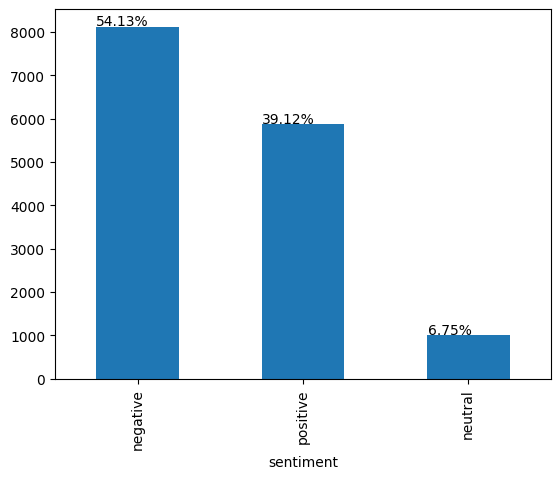

In [8]:
label = df['sentiment'].value_counts()
ax = label.plot.bar()
n = len(df.index)
print("Total data : {} entries".format(n))
for p in ax.patches:
    ax.annotate(str(round(p.get_height() / n * 100, 2)) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))

# Save Dataset

In [38]:
# Remove unused field from dataset
dataset = df.drop(
    [
        'reviewId', 
        'userName', 
        'userImage', 
        'thumbsUpCount', 
        'reviewCreatedVersion', 
        'at', 
        'replyContent', 
        'repliedAt', 
        'appVersion', 
        'score',
        'text_clean',
        'text_casefolding',
        'text_slangwords',
        'text_tokenizingText',
        'text_stopword',
        'polarity_score'
    ], axis=1)

new_header = {'content' : "Text Original", 'text_akhir' : 'Text Clean', 'sentiment' : 'Sentiment'}
dataset.rename(columns=new_header, inplace=True)

# Saving daataset
dataset.to_csv("dataset_pubg.csv", index=False)

dataset.head()

,Text Original,Text Clean,Sentiment
0,Tidak suka bermain event atau gameplay mode te...,suka bermain event gameplay mode tema menguran...,positive
1,Update terbaru update yang paling kacau selama...,update terbaru update kacau main pubg pengatur...,negative
2,Saya heran kenapa orang2 pada punya masalah ky...,heran orang frame drop render ngebug sinyal ng...,negative
3,"gamenya bagus banget, tapi saya punya sedikit ...",gamenya bagus banget keluhan gamenya berat mai...,negative
4,"Setelah update, grafik menuru walaupun sudah d...",update grafik menuru setingan blur frame rate ...,neutral


In [39]:
min = 0
for text in df['text_stopword']:
    # print(text)
    count = len(text)
    # print(count)
    if count > min :
        min = count
        max = count
    # print("Nilai Max Now : {} | Nilai Baca : {}".format(max, count))
print("Kalimat terpanjang terdiri dari {} kata". format(max))

Kalimat terpanjang terdiri dari 71 kata
